<a href="https://colab.research.google.com/github/lohaoxi/basic-pytorch-gans/blob/master/02_conditional_gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import math

import scipy.linalg
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision.models import inception_v3

if not os.path.exists('visuals'):
    os.mkdir('visuals')

In [2]:
BATCH_SIZE = 64
K = 4
N_EPOCHS = 4096
NOISE_DIM = 100
IMAGE_DIM = 28*28
MAXOUT_SIZE = 5
HIDDEN_DIM = (240, 240)
LABEL_DIM = 10

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FlattenTransform:
    
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)

data_train = torchvision.datasets.MNIST(
    "./data/mnist", 
    train=True, 
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        FlattenTransform()
        ])
    )

loader_train = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
    )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
print("Number of observation: {0}".format(len(data_train)))
print("Size of each observation: {0}".format(np.array(data_train[0][0]).shape))

Number of observation: 60000
Size of each observation: (1, 784)


In [5]:
class Maxout(nn.Module):

    def __init__(self, n_pieces):
        super(Maxout, self).__init__()
        self.n_pieces = n_pieces
        
    def forward(self, batch):
        assert batch.shape[1] % self.n_pieces == 0
        batch = batch.view(
            batch.shape[0], 
            batch.shape[1] // self.n_pieces, 
            self.n_pieces
            )
        batch, _ = batch.max(dim=2)
        return batch

class Generator(torch.nn.Module):
    
    def __init__(self, noise_dim, lbl_dim, hid_dim, out_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.lbl_dim = lbl_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.fcn = nn.Sequential(
            # Fully Connected Layer 1
            nn.Linear(self.noise_dim + self.lbl_dim, self.hid_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully Connected Layer 2
            nn.Linear(self.hid_dim, self.hid_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully Connected Layer 3
            nn.Linear(self.hid_dim, self.hid_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully Connected Layer 4
            nn.Linear(self.hid_dim, self.hid_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully Connected Layer 5
            nn.Linear(self.hid_dim, self.hid_dim, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Fully Connected Layer 6
            nn.Linear(self.hid_dim, self.out_dim, bias=True),
            nn.Sigmoid()
        )

    def forward(self, batch, labels):
        inputs = batch.view(batch.size(0), -1)
        ret = torch.cat((inputs, labels), dim=1)
        ret = self.fcn(ret)
        return ret

class Discriminator(torch.nn.Module):
            
    def __init__(self, in_dim, lbl_dim, hid_dim, out_dim, maxout_size):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.lbl_dim = lbl_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.maxout_size = maxout_size
        self.fcn = nn.Sequential(
            # Fully Connected Layer 1
            nn.Linear(self.in_dim + self.lbl_dim, self.hid_dim, bias=True),
            Maxout(5),
            nn.Dropout(0.5),
            # Fully Connected Layer 2
            nn.Linear(self.hid_dim // self.maxout_size, self.hid_dim, bias=True),
            Maxout(5),
            nn.Dropout(0.5),
            # Fully Connected Layer 3
            nn.Linear(self.hid_dim // self.maxout_size, self.hid_dim, bias=True),
            Maxout(5),
            nn.Dropout(0.5),
            # Fully Connected Layer 4
            nn.Linear(self.hid_dim // self.maxout_size, self.out_dim, bias=True),
            nn.Sigmoid()
        )

    def forward(self, batch, labels):
        ret = batch.view(batch.size(0), -1)
        ret = torch.cat((ret, labels), dim=1)
        ret = self.fcn(ret)
        return ret

generator = Generator(NOISE_DIM, LABEL_DIM, HIDDEN_DIM[0], IMAGE_DIM).to(device)
discriminator = Discriminator(IMAGE_DIM, LABEL_DIM, HIDDEN_DIM[1], 1, MAXOUT_SIZE).to(device)

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters in the Generatoris: {}".format(count_parameters(generator)))
print("Number of parameters in the Discriminator: {}".format(count_parameters(discriminator)))

Number of parameters in the Generatoris: 446944
Number of parameters in the Discriminator: 214369


In [7]:
def encodeOneHot(lbls, lbl_dim):
    ret = torch.FloatTensor(lbls.shape[0], lbl_dim)
    ret.zero_()
    ret.scatter_(dim=1, index=lbls.view(-1, 1), value=1)
    return ret

In [8]:
lbls_real = torch.ones(BATCH_SIZE, 1).to(device)
lbls_fake = torch.zeros(BATCH_SIZE, 1).to(device)

test_z = (2 * torch.randn(10, NOISE_DIM) - 1).to(device)
test_y = encodeOneHot(lbls=torch.tensor(np.arange(0, 10)), 
                      lbl_dim=LABEL_DIM).to(device)

num_steps = len(loader_train) // BATCH_SIZE

discriminator_optimizer = torch.optim.SGD(
    discriminator.parameters(),
    lr=0.002,
    momentum=0.7
)

generator_optimizer = torch.optim.SGD(
    generator.parameters(),
    lr=0.002,
    momentum=0.7
)

criterion = torch.nn.BCELoss()

In [9]:
def visualizeGAN(imgs, lbls, epoch):

    fig, axes = plt.subplots(2, 5, figsize=(20, 18))
    
    fig.suptitle('Epoch {}'.format(str(epoch).zfill(4)))

    for row, axe in enumerate(axes):
        for col, cell in enumerate(axe):
            cell.imshow(
                imgs[row * 5 + col],
                cmap='gray'
            )
            
            cell.set_title('{}'.format(
                torch.argmax(lbls[row * 5 + col])
            ))

            cell.axis("off")


    plt.axis("off")
    plt.tight_layout()

    fig.savefig(os.path.join("visuals", "{}.jpg".format(str(epoch).zfill(6))))
    
    plt.close()

In [10]:
d_loss_ls = []
g_loss_ls = []
d_lr_ls = []
g_lr_ls = []


for epoch in range(N_EPOCHS):
    
    # Loss Log
    d_counter = 0
    g_counter = 0
    d_loss = 0
    g_loss = 0

    for i, (images, labels) in enumerate(loader_train):

        if i == num_steps:
            break

        # Train Discriminator
        for _ in range(4):
        
            real_conditions = encodeOneHot(
                labels, 
                LABEL_DIM).to(device)

            real_images = images.to(device)

            fake_conditions = encodeOneHot(
                torch.randint(0, 10, (BATCH_SIZE,)), 
                LABEL_DIM).to(device)
                
            fake_images = generator(
                (2 * torch.randn(BATCH_SIZE, NOISE_DIM) - 1).to(device),
                fake_conditions
            )

            discriminator_optimizer.zero_grad()
            
            real_outputs = discriminator(real_images, real_conditions)
            fake_outputs = discriminator(fake_images, fake_conditions)
            
            d_x = criterion(real_outputs, lbls_real)
            d_g_z = criterion(fake_outputs, lbls_fake)

            d_x.backward()
            d_g_z.backward()

            discriminator_optimizer.step()
            
            d_counter += 1
            d_loss = d_x.item() + d_g_z.item()


        # Train Generator
        z = (2 * torch.randn(BATCH_SIZE, NOISE_DIM) - 1).to(device)
        y = encodeOneHot(torch.randint(0, 10, (BATCH_SIZE,)), LABEL_DIM).to(device)

        generator.zero_grad()

        outputs = discriminator(generator(z, y), y)

        loss = criterion(outputs, lbls_real)

        loss.backward()

        generator_optimizer.step()

        g_counter += 1
        g_loss += loss.item()

    # Loss Log
    if epoch % 10 == 0:
        print(
            'e:{}\t| G:{:.4f}\t| D:{:.4f}\t'.format(
                str(epoch).zfill(6),
                g_loss / g_counter,
                d_loss / d_counter
            )
        )
    
    # Loss Log for Plot
    g_loss_ls.append(g_loss / g_counter)
    d_loss_ls.append(d_loss / d_counter)
    

    # Visualize Results
    if epoch % 5 == 0:

        generated = generator(test_z, test_y).detach().cpu().view(-1, 28, 28)

        visualizeGAN(generated, test_y, epoch)

e:000000	| G:0.7636	| D:0.0224	
e:000010	| G:9.4625	| D:0.0030	
e:000020	| G:5.9956	| D:0.0071	
e:000030	| G:4.9988	| D:0.0031	
e:000040	| G:7.7918	| D:0.0009	
e:000050	| G:9.5055	| D:0.0005	
e:000060	| G:9.4233	| D:0.0010	
e:000070	| G:9.8293	| D:0.0009	
e:000080	| G:9.8245	| D:0.0003	
e:000090	| G:9.4553	| D:0.0006	
e:000100	| G:9.4873	| D:0.0010	
e:000110	| G:8.9993	| D:0.0007	
e:000120	| G:9.3917	| D:0.0007	
e:000130	| G:9.3789	| D:0.0007	
e:000140	| G:9.4839	| D:0.0007	
e:000150	| G:9.7178	| D:0.0015	
e:000160	| G:8.9671	| D:0.0014	
e:000170	| G:9.3592	| D:0.0005	
e:000180	| G:8.6409	| D:0.0006	
e:000190	| G:8.9755	| D:0.0008	
e:000200	| G:9.1901	| D:0.0019	
e:000210	| G:9.1597	| D:0.0020	
e:000220	| G:8.9308	| D:0.0013	
e:000230	| G:8.7320	| D:0.0016	
e:000240	| G:8.3827	| D:0.0005	
e:000250	| G:8.4769	| D:0.0029	
e:000260	| G:8.2791	| D:0.0023	
e:000270	| G:7.8127	| D:0.0023	
e:000280	| G:7.7414	| D:0.0023	
e:000290	| G:7.6020	| D:0.0036	
e:000300	| G:7.5333	| D:0.0023	
e:000310

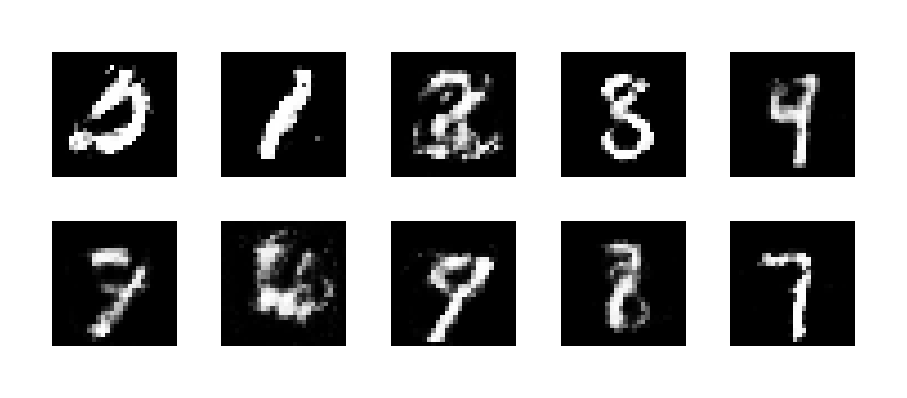

In [11]:
# Visualize Results
test_z = (2 * torch.randn(10, NOISE_DIM) - 1).to(device)

generated = generator(test_z, test_y).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(
    generated,
    nrow=5,
    padding=10,
    pad_value=1
)

img = np.transpose(
    grid.numpy(),
    (1, 2, 0)
)

fig = plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(img);